# Build a CNN using real image data
Use the cats and dogs dataset from Kaggle. This dataset can be downloaded [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [2]:
import nntplib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### Examine the data

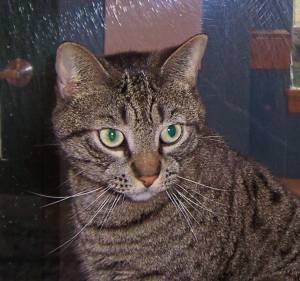

In [3]:
with Image.open('../Data/CATS_AND_DOGS/PetImages/Cat/1.jpg') as im:
    display(im)

In [10]:
# Track filepaths of all images
pth = '../Data/CATS_AND_DOGS/PetImages'

def grab_images(path: str, cat_or_dog: str) -> list:
    filepaths = []
    for file in os.listdir(os.path.join(path, cat_or_dog)):
        filepath = os.path.join(path, cat_or_dog, file)
        filepaths.append(filepath)
    return filepaths

cats = grab_images(pth, 'Cat')
dogs = grab_images(pth, 'Dog')

img_filepaths = cats + dogs
len(img_filepaths)

25002

In [13]:
# Explore image sizes
img_sizes = []
rejected = []

for item in img_filepaths:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

In [16]:
print('Rejected: ', rejected)
print('\nTotal accepted: ', len(img_sizes))

Rejected:  ['../Data/CATS_AND_DOGS/PetImages\\Cat\\666.jpg', '../Data/CATS_AND_DOGS/PetImages\\Cat\\Thumbs.db', '../Data/CATS_AND_DOGS/PetImages\\Dog\\11702.jpg', '../Data/CATS_AND_DOGS/PetImages\\Dog\\153.jpg', '../Data/CATS_AND_DOGS/PetImages\\Dog\\Thumbs.db']

Total accepted:  24997


In [19]:
df = pd.DataFrame(img_sizes, columns=['Width', 'Height'])
df.head()

,Width,Height
0,500,375
1,300,281
2,489,500
3,403,500
4,150,150


In [20]:
df['Width'].describe()

count    24997.000000
mean       404.443373
std        109.000463
min          4.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: Width, dtype: float64

In [21]:
df['Height'].describe()

count    24997.000000
mean       360.988519
std         97.007291
min          4.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: Height, dtype: float64

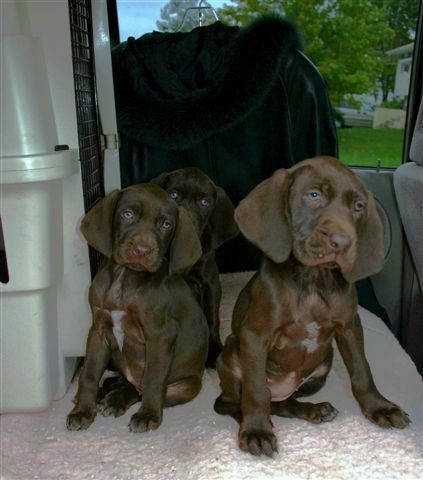

In [22]:
# Open single image of dog
dog = Image.open(dogs[100])
display(dog)

In [23]:
dog.size

(423, 480)

In [24]:
# Check out top left pixel value
dog.getpixel((0,0))
# Some value between 0 and 255

(116, 121, 114)

In [26]:
# Define a transform - we need to turn our .jpg files into tensors. We will be performing a variety of transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

im = transform(dog)
print('Type: ', type(im))
print('Shape: ', im.shape)  # color channels, length, width

Type:  <class 'torch.Tensor'>
Shape:  torch.Size([3, 480, 423])


In [29]:
# To view image using matplotlib, we need to pass it as l, w and color channels instead of c, l, w
np.transpose(im.numpy(), (1,2,0))

array([[[0.45490196, 0.4745098 , 0.44705883],
        [0.49803922, 0.5176471 , 0.49019608],
        [0.45882353, 0.47843137, 0.4509804 ],
        ...,
        [0.01176471, 0.07450981, 0.03529412],
        [0.02745098, 0.09019608, 0.05098039],
        [0.20392157, 0.2627451 , 0.24313726]],

       [[0.47058824, 0.49019608, 0.4627451 ],
        [0.5137255 , 0.53333336, 0.5058824 ],
        [0.4745098 , 0.49411765, 0.46666667],
        ...,
        [0.        , 0.05490196, 0.01176471],
        [0.03137255, 0.09411765, 0.05490196],
        [0.21568628, 0.27450982, 0.24705882]],

       [[0.45882353, 0.47843137, 0.45490196],
        [0.5019608 , 0.52156866, 0.49803922],
        [0.4627451 , 0.48235294, 0.45490196],
        ...,
        [0.        , 0.05490196, 0.00784314],
        [0.03921569, 0.10588235, 0.06666667],
        [0.20784314, 0.27450982, 0.24313726]],

       ...,

       [[0.65882355, 0.59607846, 0.59607846],
        [0.7607843 , 0.69803923, 0.69803923],
        [0.75686276, 0

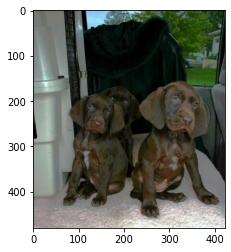

In [30]:
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [32]:
# Notice above that after converting the image to a numpy arrya, the pixel values are normalized
im[:,0,0]

tensor([0.4549, 0.4745, 0.4471])

In [33]:
dog.getpixel((0,0))

(116, 121, 114)

In [34]:
np.array((116,121,114))/255

array([0.45490196, 0.4745098 , 0.44705882])

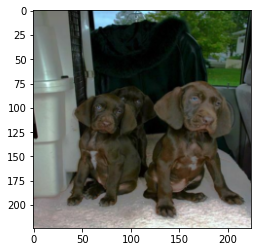

In [36]:
# Resize the image
transform = transforms.Compose([
    # pass 224 on its own to resize the smaller edge. Pass (224,224) to resize as a square  
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

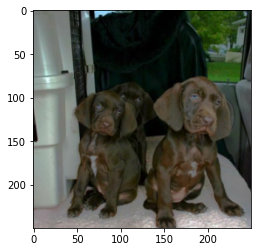

In [38]:
# Center crop
# Resize image to a box of defined size in the center of the image
# It's common to do a resize then a center crop
transform = transforms.Compose([
    transforms.Resize(250),  # small edge to 250 px
    transforms.CenterCrop(250),  # remove "noise" above and below puppers
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

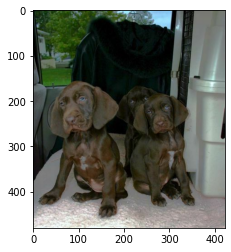

In [39]:
# Random horizontal flip
# Apply right before passing a batch to the model
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # 100% probability that it'll be flipped
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

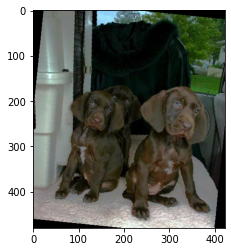

In [40]:
# Random rotation
# Apply right before passing a batch to the model
transform = transforms.Compose([
    transforms.RandomRotation(30),  # randomly rotate in range of +/- 30 degrees
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

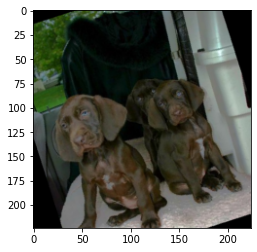

In [41]:
# Big ol' group of transformations (and puppos)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.RandomRotation(30),  # randomly rotate in range of +/- 30 degrees
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

### IMPORTANT NOTE!
When using someone else's pretrained models, it's important to transform your images in exactly the same way as the images the pretrained model was trained on!!

For example, a pretrained model might normalize pixel rgb values to between -0.5 and 0.5. As seen above, we normalized between 0 and 1. We would want to change that in order to pass our images through such a pretrained model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


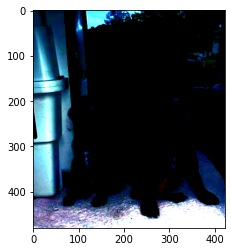

In [43]:
# Specific transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # There's research backing these particular values for mean and std, supporting why they work well in practice. I don't really care about that right now, though, so I'll just take the values at face value
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # [R, G, B]
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [44]:
# "De"-normalize values
im

tensor([[[-0.1314,  0.0569, -0.1143,  ..., -2.0665, -1.9980, -1.2274],
         [-0.0629,  0.1254, -0.0458,  ..., -2.1179, -1.9809, -1.1760],
         [-0.1143,  0.0741, -0.0972,  ..., -2.1179, -1.9467, -1.2103],
         ...,
         [ 0.7591,  1.2043,  1.1872,  ...,  1.7180,  1.8893,  1.9407],
         [ 0.9132,  1.3755,  1.3413,  ...,  2.0092,  2.0777,  2.0777],
         [ 1.0502,  1.4783,  1.3927,  ...,  2.2489,  2.2489,  2.1804]],

        [[ 0.0826,  0.2752,  0.1001,  ..., -1.7031, -1.6331, -0.8627],
         [ 0.1527,  0.3452,  0.1702,  ..., -1.7906, -1.6155, -0.8102],
         [ 0.1001,  0.2927,  0.1176,  ..., -1.7906, -1.5630, -0.8102],
         ...,
         [ 0.6254,  1.0805,  1.0630,  ...,  1.8859,  2.0609,  2.1134],
         [ 0.7479,  1.2206,  1.1856,  ...,  2.1835,  2.2535,  2.2535],
         [ 0.8529,  1.2906,  1.2031,  ...,  2.4286,  2.4286,  2.3585]],

        [[ 0.1825,  0.3742,  0.1999,  ..., -1.6476, -1.5779, -0.7238],
         [ 0.2522,  0.4439,  0.2696,  ..., -1

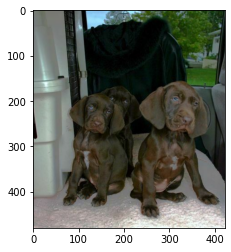

In [45]:
# Invert the normalization
inverse_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)
im_inv = inverse_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))